In [1]:
import tensorflow as tf
import os

from timeit import default_timer as timer
from IPython.display import display
import matplotlib.pyplot as plt

from reggae.data_loaders import DataHolder, HafnerData
from reggae.tf_utilities import discretise, logistic
from reggae.plot import mcmc_plotters
from reggae.mcmc.models import TranscriptionMixedSampler
from reggae.mcmc import Options

import numpy as np
import pandas as pd
import arviz

plt.style.use('ggplot')
%matplotlib inline
f64 = np.float64
np.set_printoptions(threshold=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.10f}".format(x)})

In [2]:
target_genes = [
    'KAZN','PMAIP1','PRKAB1','CSNK1G1','E2F7','SLC30A1',
    'PTP4A1','RAP2B','SUSD6','UBR5-AS1','RNF19B','AEN','ZNF79','XPC',
    'FAM212B','SESN2','DCP1B','MDM2','GADD45A','SESN1','CDKN1A','BTG2'
]
known_target_genes = [
    'CDKN1A', #p21
    'SESN1', #hPA26
    'DDB2',
    'TNFRSF10B',
    'BIK',
]
dataset = HafnerData(replicate=None, data_dir='../data/', extra_targets=False)
num_replicates = 2
num_genes = len(dataset.gene_names)
num_tfs = 1
num_times = dataset[0][0].shape[0]

t_observed = np.arange(0, 13)
t_predict = tf.linspace(0, 13, 80)

m_observed = np.stack([
    dataset[i][1] for i in range(num_genes*num_replicates)
])
m_observed = m_observed.reshape(num_replicates, num_genes, num_times)
m_observed = np.float64(m_observed)
print(type(m_observed))
f_observed = dataset.tfs

replicate = 0

τ, common_indices = discretise(t_observed, num_disc=13)
data = DataHolder((m_observed, f_observed), None, (t_observed, τ, tf.constant(common_indices)))

print(f_observed.shape, m_observed.shape)


<class 'numpy.ndarray'>
(2, 1, 13) (2, 22, 13)


In [3]:
opt = Options(preprocessing_variance=False,
              tf_mrna_present=True,
              delays=False,
              weights=False,
              kinetic_exponential=True,
              initial_step_sizes={'logistic': 0.000005, 'latents': 10},
              kernel='rbf')

model = TranscriptionMixedSampler(data, opt)

In [ ]:

start = timer()
samples, is_accepted = model.sample(T=500, burn_in=0)
end = timer()
print(f'Time taken: {(end - start):.04f}s')

----- Sampling Begins -----
log prob (22, 4)
kbar shape (22, 4)
log prob (22, 4)
log prob (22, 4)
log prob (22, 4)
log prob (22, 4)
Updating step_size 10 due to acc rate 0.31000000000000016
Updating step_size 9 due to acc rate 0.21500000000000025


In [6]:
do_save = False
do_load = False
if do_save:
    model.save('human')
if do_load:
    # Initialise from saved model:
    model = TranscriptionMixedSampler.load('human', [data, opt])
    is_accepted = model.is_accepted

In [7]:
pcs = list()
for i, param in enumerate(model.state_indices):
    pcs.append(tf.reduce_mean(tf.cast(is_accepted[i], dtype=tf.float32)).numpy())

display(pd.DataFrame([[f'{100*pc:.02f}%' for pc in pcs]], columns=list(model.state_indices)))

plot_opt = mcmc_plotters.PlotOptions(
    num_plot_genes=10, num_plot_tfs=10,
    gene_names=np.array(dataset.gene_names), tf_names=['p53'],
    true_label='Hafner et al.', for_report=True, ylabel='normalised FPKM',
    kernel_names=model.kernel_selector.names(), num_hpd=200
)
plotter = mcmc_plotters.Plotter(data, plot_opt)

# Calculate gene samples
σ2_f = None
results = model.results()



,kinetics,latents,σ2_m,σ2_f
0,0.00%,58.00%,100.00%,100.00%


In [8]:
m_preds = model.sample_latents(results, 20)

kbar shape (22, 4)


In [9]:

dec = np.array([0.284200056, 0.399638904, 0.062061123]) #todo incorrect order
sens = np.array([4.002484948, 32.89511304, 4.297906129])
# np.array([0, *dec, 0])
sens = np.array([
    0.232461671,0.429175332,1.913169606,0.569821512,2.139812962,0.340465324,
    4.203117214,0.635328943,0.920901229,0.263968666,1.360004451,4.816673998,
    0.294392325,2.281036308,0.86918333,2.025737447,1.225920534,11.39455009,
    4.229758095,4.002484948,32.89511304,7.836815916])
dec = np.array([
    0.260354271,0.253728801,0.268641114,0.153037374,0.472215028,0.185626363,
    0.210251586,0.211915623,0.324826082,0.207834775,0.322725728,0.370265667,
    0.221598164,0.226897275,0.409710437,0.398004589,0.357308033,0.498836353,
    0.592101838,0.284200056,0.399638904,0.463468107])

ktrue = np.zeros((num_genes, 4))
k_latest = np.mean(results.k[-40:], axis=0)
dec = dec/np.mean(dec)* np.mean(k_latest[:,2])
ktrue[:,2] = 1.02*dec

sens = sens/np.mean(sens)* np.mean(k_latest[:,3])
ktrue[:,3] = sens

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


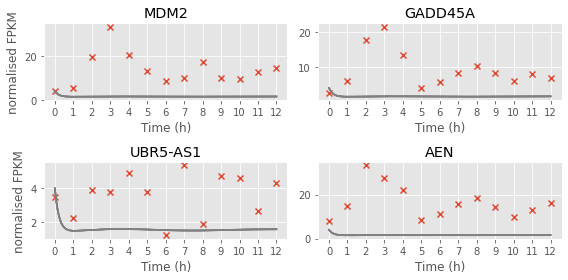

In [10]:
print(type(m_preds))
print(type((data.m_obs)))
plotter.plot_genes(m_preds, replicate=0, height_mul=2, indices=[5, 11, 20, 21])
# plt.legend(bbox_to_anchor=(0, -1));

(22, 4) tf.Tensor(0.9933071492158705, shape=(), dtype=float64)
(2, 22, 169)


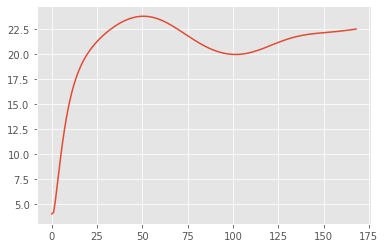

In [11]:
k = results.k[-1]
k[-2, 3] = tf.exp(5.)
print(k.shape, logistic(np.log(k[-2, 3])))
m_pred = model.likelihood.predict_m(logistic(np.log(k)), results.k_fbar[-1], results.wbar[-1],
                           results.fbar[-1], results.w_0bar[-1], None)
print(m_pred.shape)
plt.plot(m_pred[0, -2])


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\arviz\stats\stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


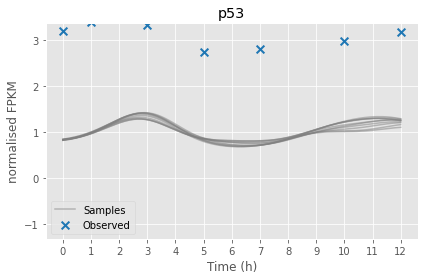

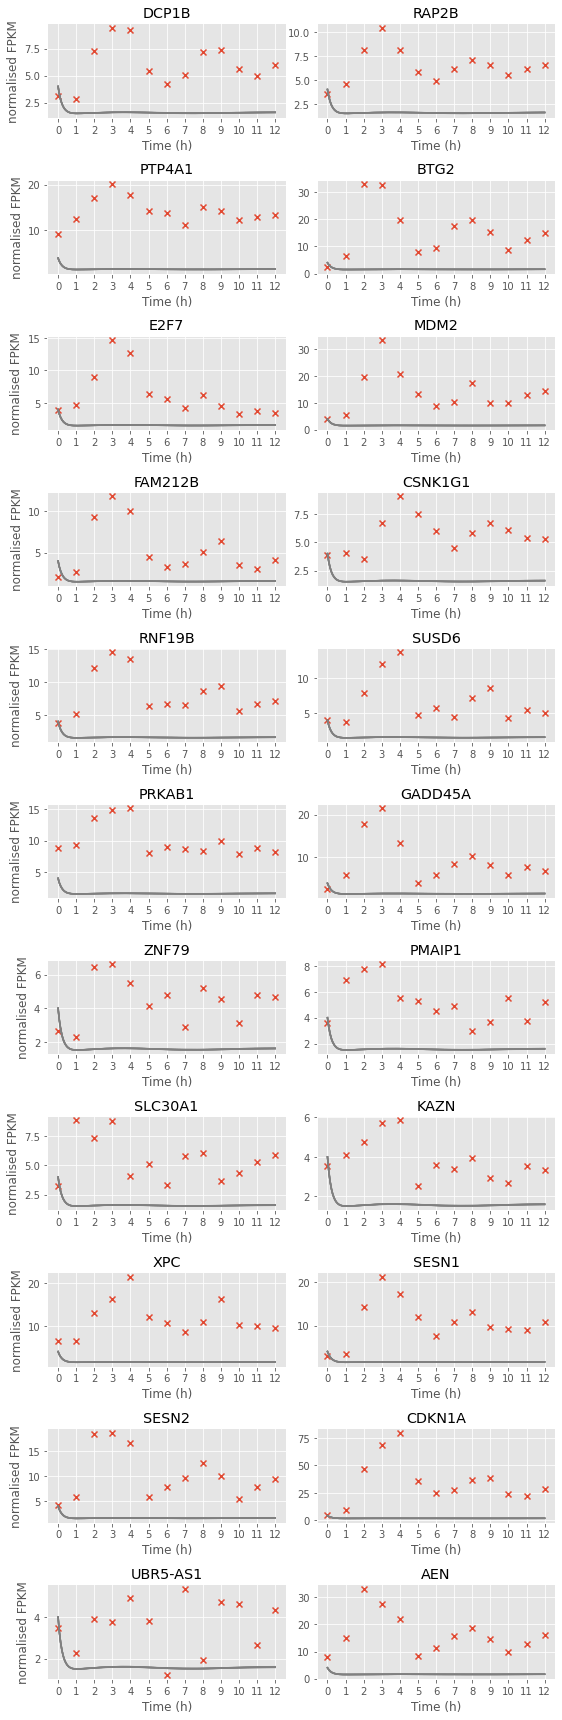

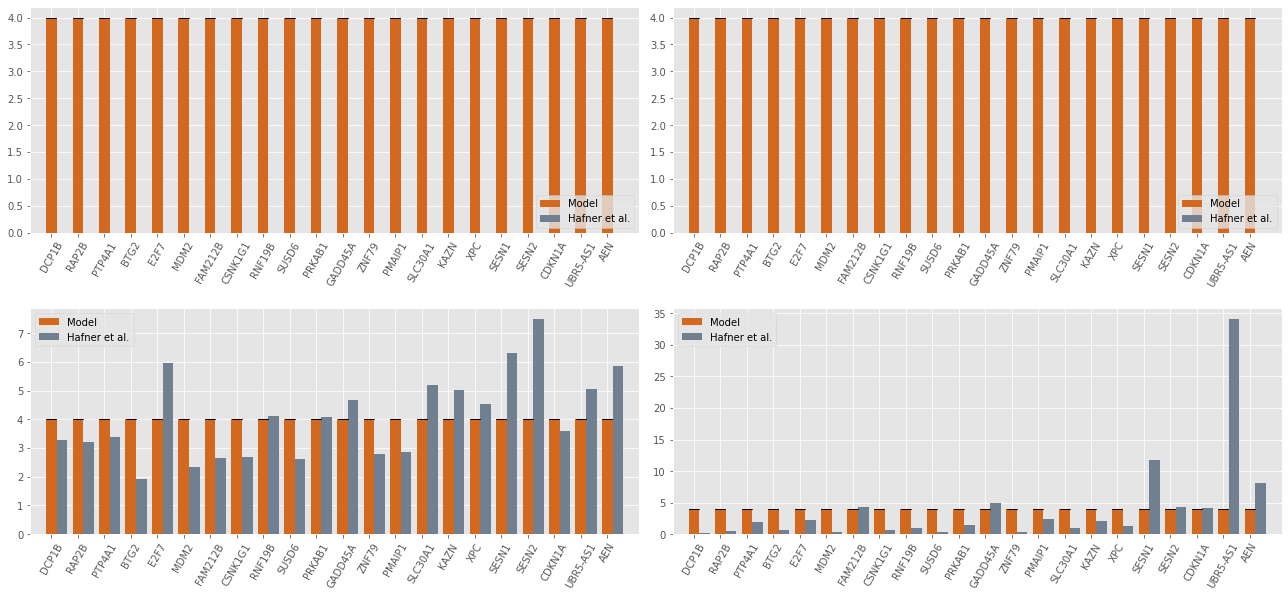

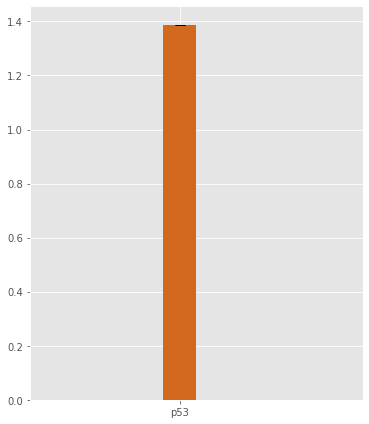

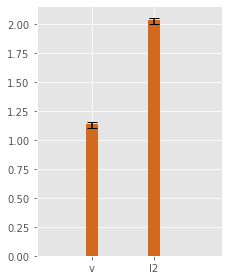

In [12]:
plotter.summary(results, m_preds, true_k=ktrue, replicate=0, scale_observed=True)


No handles with labels found to put in legend.


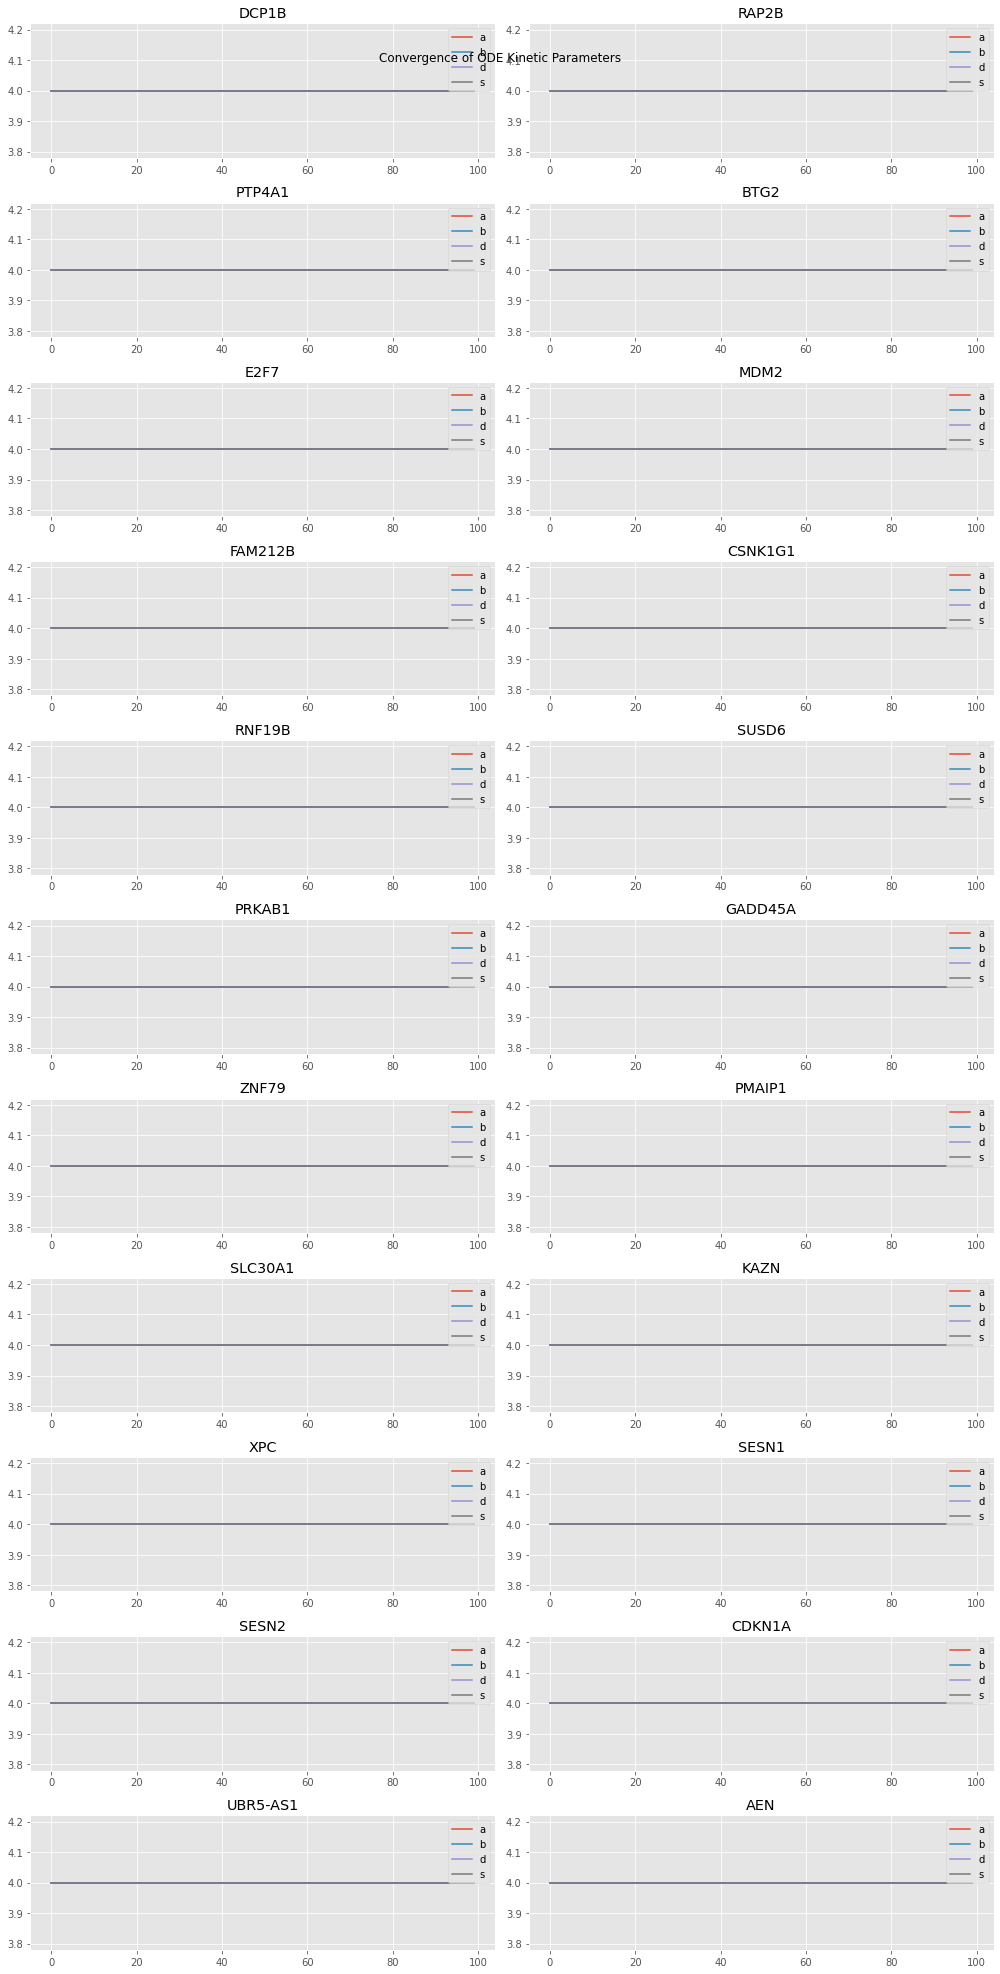

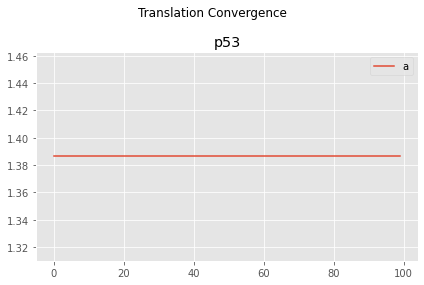

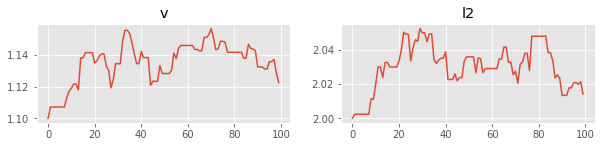

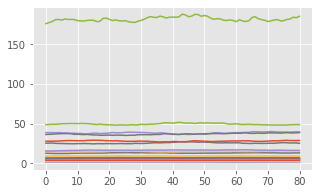

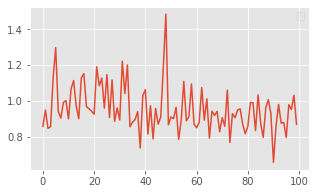

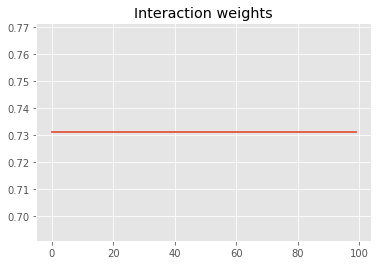

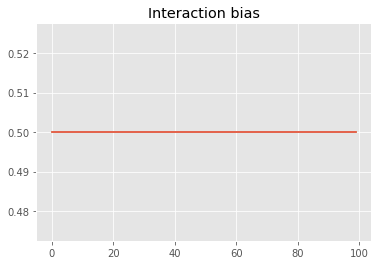

In [13]:
plotter.convergence_summary(results)


In [14]:
plotter.plot_grn(results)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# Plot proteins
p_samples = model.sample_proteins(results, 20)[:,0]
print(p_samples.shape)
plotter.plot_samples(p_samples, [''], 4, color='orangered')
plt.xlim(0, 10)
plt.ylim(-0.05, 2.5)
print(8.51/4.72)
plt.figure(figsize=(4*1.80297, 4))
p = p_samples[-1]
y = [1.5, 4.8, 13.7, 5, 2, 1.4, 3.2, 4, 1.4, 1.5]
# y = y/np.mean(y)*np.mean(p) * 1.75-0.16
# y = scaler.fit_transform(np.expand_dims(y, 0))
plt.plot(t[1:11], y)
plt.ylim(0, 15)
plt.ylabel('p53 fold change')
plt.xlabel('Time (h)')
plt.xticks(np.arange(1, 11))
plt.yticks(np.arange(0, 16, 5))

plt.tight_layout()

